<a href="https://colab.research.google.com/github/AditiSatsangi/Identification-of-medicina-plants-using-CNN/blob/main/Plants_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#Install kaggle API client
!pip install -q kaggle

In [ ]:
!mkdir  ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
mv kaggle.json /root/.kaggle/


In [ ]:
#to set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
#list all available datasets
!kaggle datasets list

# Downloading dataset

In [ ]:
!kaggle datasets download -d aryashah2k/indian-medicinal-leaves-dataset

100% 9.00G/9.00G [01:37<00:00, 136MB/s]
100% 9.00G/9.00G [01:38<00:00, 98.6MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  indian-medicinal-leaves-dataset.zip
replace Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Aloevera/10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import numpy as np

In [ ]:
dataset_path= 'Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset'

In [ ]:
def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    # Iterate through class directories
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        class_label = int(class_dir)  # Convert directory name to label if needed

        # Iterate through images in the class directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Read and preprocess the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = image.astype(np.float32) / 255.0  # Normalize pixel values

            # Append the image and label to lists
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels)


In [ ]:
for images, labels in data.take(1):  # Take one batch from the dataset
    print(labels)
    #print(images)

tf.Tensor(
[58 28  6 52  6 67 65 63 56 58  5 31 66 23 13 32 60 69 69 35 32 63 44 70
 42 65 39 23 25 30 25  7], shape=(32,), dtype=int32)


# **Transfer Learning with MobileNet Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Constants
IMAGE_RES = 224
BATCH_SIZE = 32
# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    'Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset',
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% of the data will be used for testing
    subset="training",     # Specify "training" to get the training subset
    seed=42,
    label_mode='int'
)
num_examples = data.cardinality().numpy()
num_classes = len(data.class_names)

# Split the data into training and testing
testing_data = tf.keras.utils.image_dataset_from_directory(
    'Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset',
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # No validation split for testing
    seed=42,
    label_mode='int',
    subset="validation"    # Specify "validation" to get the testing subset
)

Found 6900 files belonging to 80 classes.
Using 5520 files for training.
Found 6900 files belonging to 80 classes.
Using 1380 files for validation.


In [ ]:
# Constants
IMAGE_RES = 224  # InceptionV3 input shape
BATCH_SIZE = 32

# Training Model

In [ ]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label
train_data = data
# Define the validation split ratio
validation_split = 0.2
num_validation_samples = int(num_examples * validation_split)
validation_data = data.take(num_validation_samples)

train_batches = train_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = validation_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_RES, IMAGE_RES, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Create the final model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(train_batches, validation_data=validation_batches, epochs=10)

# Evaluate the model on the testing dataset
testing_batches = testing_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(testing_batches)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

Epoch 1/10
173/173 [==============================] - 412s 2s/step - loss: 2.3744 - accuracy: 0.4601 - val_loss: 0.9869 - val_accuracy: 0.7950
Epoch 2/10
173/173 [==============================] - 217s 1s/step - loss: 0.8197 - accuracy: 0.8275 - val_loss: 0.5426 - val_accuracy: 0.8814
Epoch 3/10
173/173 [==============================] - 219s 1s/step - loss: 0.4848 - accuracy: 0.9125 - val_loss: 0.3540 - val_accuracy: 0.9393
Epoch 4/10
173/173 [==============================] - 215s 1s/step - loss: 0.3234 - accuracy: 0.9524 - val_loss: 0.2523 - val_accuracy: 0.9651
Epoch 5/10
173/173 [==============================] - 217s 1s/step - loss: 0.2294 - accuracy: 0.9755 - val_loss: 0.1891 - val_accuracy: 0.9807
Epoch 6/10
173/173 [==============================] - 209s 1s/step - loss: 0.1698 - accuracy: 0.9864 - val_loss: 0.1467 - val_accuracy: 0.9871
Epoch 7/10
173/173 [==============================] - 211s 1s/step - loss: 0.1298 - accuracy: 0.9931 - val_loss: 0.1168 - val_accuracy: 0.9945

# Model's Description

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_7  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 80)                102480    
                                                                 
Total params: 2360464 (9.00 MB)
Trainable params: 102480 (400.31 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


# Plot for training and validation

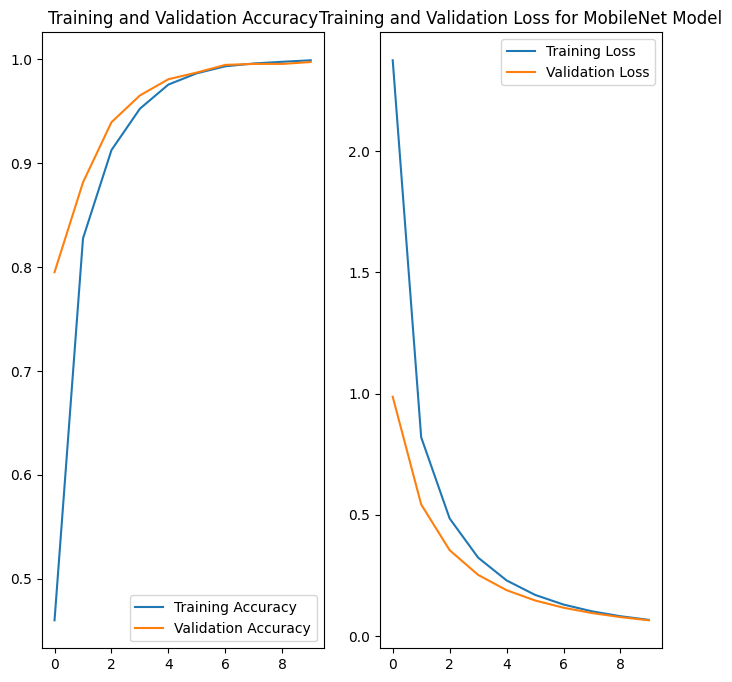

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for MobileNet Model')
plt.show()

In [ ]:
import tensorflow as tf
# Suppress TensorFlow warnings
tf.get_logger().setLevel("ERROR")
# Save the trained model to a file
model.save("Model_Mobilenet.h5")
# Download the saved model file
from google.colab import files
files.download("Model_Mobilenet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Prediction**

1/1 [==============================] - 0s 63ms/step


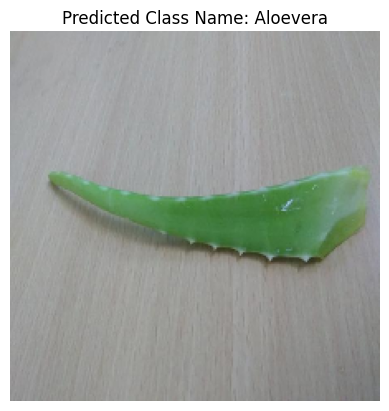

In [ ]:
input_image_path = 'Im.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 66ms/step


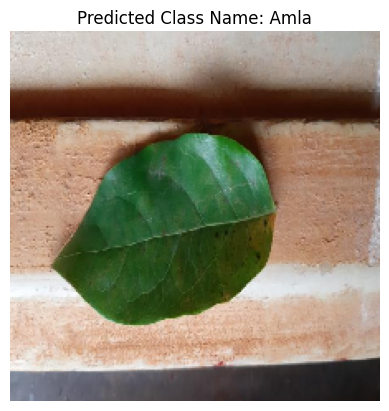

In [ ]:
input_image_path = 'AMLA.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 57ms/step


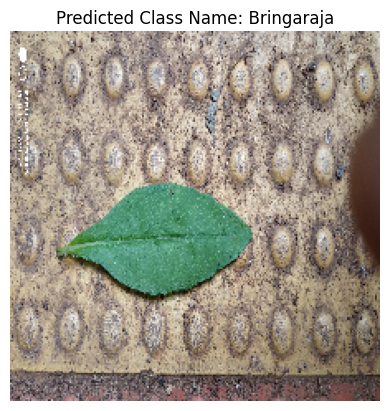

In [ ]:
input_image_path = 'Bhringaraj.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]

plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 195ms/step


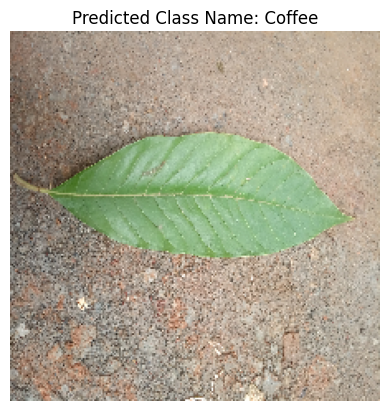

In [ ]:
input_image_path = 'Coffee .jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]

plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()